## Single image processing

The purpose of this example is to show how to retrieve an AuxTel raw image, run a simple pipetask on it to create a calibrated exposure 
(calexp) and then to retrieve the calexp and extract the PSF model from it. 

We will use the image mentionned by Chris Stubbs in https://lsstc.slack.com/archives/CLQ63T89L/p1711083752132269 which is supposed to have
a very good seeing

The exposure number is 2024032100125

In [132]:
# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.geom as geom

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 
%config Completer.use_jedi = False

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
butler_path = "/sdf/data/rubin/repo/embargo"
butler = dafButler.Butler(butler_path)
registry = butler.registry

In [134]:
for dst in sorted(registry.queryDatasetTypes()):
    if "raw" in dst.name:
        print(dst)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('rawSpectrum', {band, instrument, detector, physical_filter, exposure}, FiberSpectrum)


In [137]:
# The dataset that we are looking for will be in the collection "LATISS/raw/all" which contains all the AuxTel raw data
collections=['LATISS/raw/all']
refs = list(set(registry.queryDatasets(datasetType="raw", collections=collections, 
           where= "instrument='LATISS' AND band='r' AND exposure=2024032100125")))
print(len(refs))

1


In [139]:
# Get more metadata related to this dataset
for dim in ['exposure', 'detector']:
    print(list(registry.queryDimensionRecords(dim, where="instrument='LATISS' AND exposure = 2024032100125"))[0])
    print()

exposure:
  instrument: 'LATISS'
  id: 2024032100125
  physical_filter: 'SDSSr_65mm~empty'
  obs_id: 'AT_O_20240321_000125'
  exposure_time: 20.0
  dark_time: 20.2441
  observation_type: 'engtest'
  observation_reason: 'focus_offset_0.00'
  day_obs: 20240321
  seq_num: 125
  seq_start: 125
  seq_end: 125
  group_name: '2024-03-22T02:31:44.636'
  group_id: 2910043046360000
  target_name: 'HD  98802'
  science_program: 'cwfs-focus-sweep'
  tracking_ra: 170.28928601055472
  tracking_dec: -48.63003249987499
  sky_angle: 239.78986603747745
  azimuth: 142.76480229372243
  zenith_angle: 25.676062487753896
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2024-03-22 02:31:48.624020', scale='tai', format='iso'), end=astropy.time.Time('2024-03-22 02:32:08.868000', scale='tai', format='iso'))

detector:
  instrument: 'LATISS'
  id: 0
  full_name: 'RXX_S00'
  name_in_raft: 'RXX_S00'
  raft: None
  purpose: 'SCIENCE'



In [141]:
# Now we get the raw image and display it 
im = butler.get(refs[0])

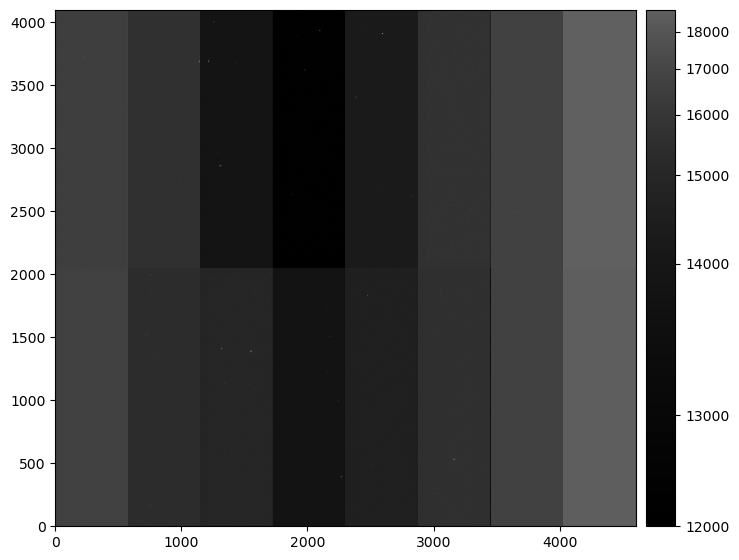

In [142]:
# Display the image cutout
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(im.image)
fig.savefig("auxtel.png")

## Run a simple pipetask to process this single exposure

The following should be executed on a terminal opened at USDF

```
mkdir test-latiss
cd test-latiss
source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2024_12/loadLSST.bash ; setup lsst_distrib
export REPO="/sdf/data/rubin/repo/embargo"
cp $DRP_PIPE_DIR/pipelines/LATISS/DRP.yaml .
```

at this point, you need to edit DRP.yaml to add the following block at the end:

```
   singleFrame:
    subset:
      - isr
      - characterizeImage
      - calibrate
      - writePreSourceTable
      - transformPreSourceTable
      - consolidatePreSourceTable
      - consolidateVisitSummary
      - isolatedStarAssociation
    description: |
      Set of tasks for complete single frame processing.
```
This will declare the subset "singleFrame" to the DRP standard pipeline. This subset is composed of 8 subtasks (isr, characterizeImage,...)

The next step will be to excute the singleFrame pipetask using the butler command:

```
pipetask run --register-dataset-types -b $REPO/butler.yaml \
    -i "LATISS/raw/all,LATISS/calib,skymaps,refcats" \
    -o u/$USER/single_frame \
    -d "instrument='LATISS' AND band='r' AND exposure=2024032100125" \
    -p DRP.yaml#singleFrame
```

In [143]:
# Check whether the user collection has been created

for c in sorted(registry.queryCollections()):
    if 'boutigny'in c :
        print(c)

u/boutigny/single_frame
u/boutigny/single_frame/20240325T160515Z


In [144]:
collections=["u/boutigny/single_frame/20240325T160515Z"]
butler = dafButler.Butler(butler_path, collections=collections)
registry = butler.registry

In [ ]:
for dst in sorted(registry.queryDatasetTypes()):
    if "psf" in dst.name.lower():
        print(dst)

In [145]:
refs = list(set(registry.queryDatasets(datasetType="postISRCCD", collections=collections, 
           where= "instrument='LATISS' AND band='r' AND exposure=2024032100125")))
refs

[DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LATISS', detector: 0, exposure: 2024032100125, band: 'r', physical_filter: 'SDSSr_65mm~empty'}, run='u/boutigny/single_frame/20240325T160515Z', id=302529dd-9ecb-4636-afaa-54b173326b2b)]

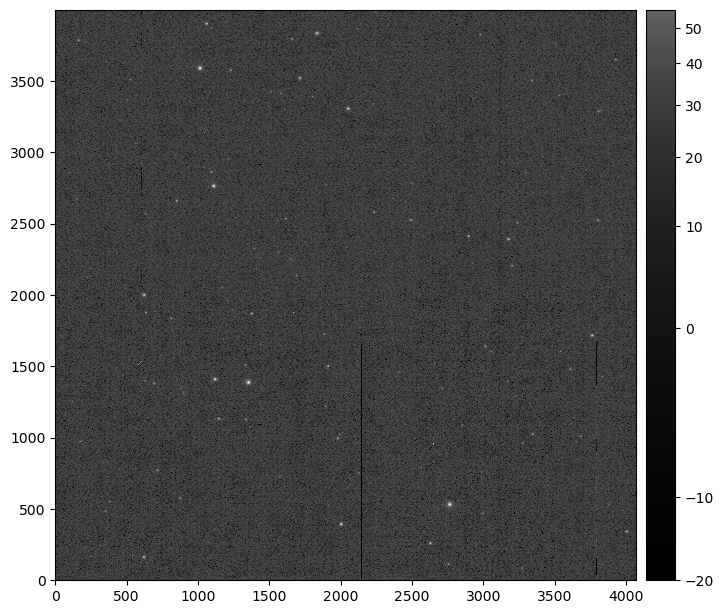

In [146]:
im = butler.get(refs[0])

# Display the image cutout
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(im.image)

In [147]:
refs = list(set(registry.queryDatasets(datasetType="calexp", collections=collections, 
           where= "instrument='LATISS' AND band='r' AND exposure=2024032100125")))
refs

[DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit}, ExposureF), {instrument: 'LATISS', detector: 0, visit: 2024032100125, band: 'r', physical_filter: 'SDSSr_65mm~empty'}, run='u/boutigny/single_frame/20240325T160515Z', id=c1d0d264-625d-4a13-93fc-c7ce9aa8450c)]

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-8.0.0/Linux64/obs_base/gae481fbbf9+66445c569b/python/lsst/obs/base/formatters/fitsExposure.py:563: FutureWarning: Summary fields [effTime, effTimePsfSigmaScale, effTimeSkyBgScale, effTimeZeroPointScale] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


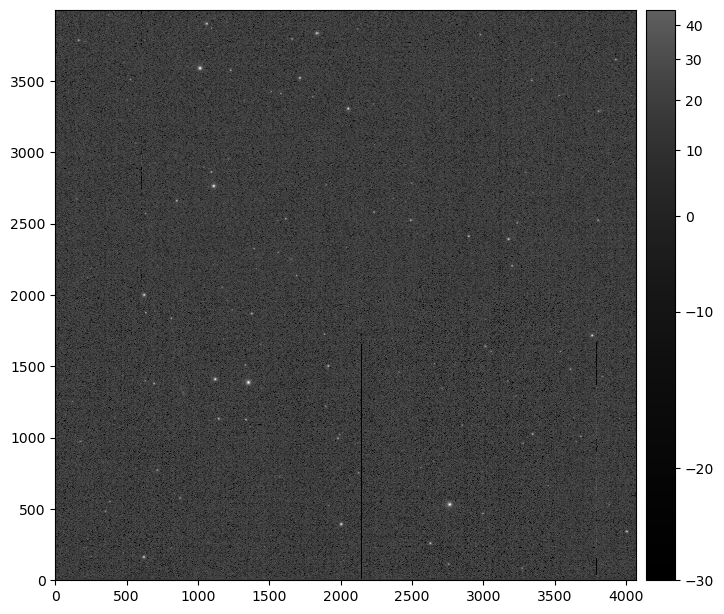

In [148]:
im = butler.get(refs[0])

# Display the image cutout
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(im.image)

In [152]:
psf = im.getPsf()

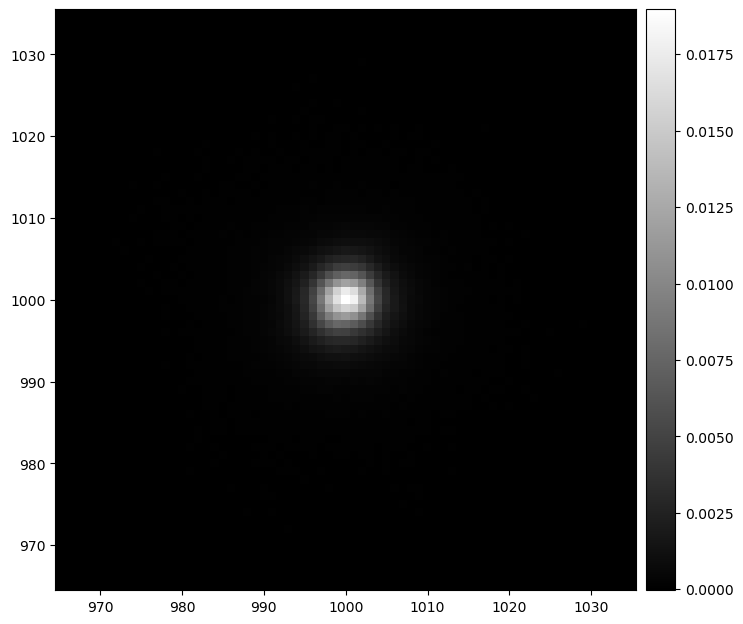

In [153]:
p = geom.Point2D(1000, 1000)
im_psf = psf.computeImage(p)
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.mtv(im_psf)

In [98]:
quad = psf.computeShape(p)

In [99]:
quad.getDeterminantRadius()

2.6909213030533645

In [100]:
psf.computePeak(p)

0.01897062174975872

In [120]:
im_psf

lsst.afw.image._image.ImageD=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], bbox=(minimum=(965, 965), maximum=(1035, 1035))

In [124]:
import numpy as np

np_psf = im_psf.array

In [129]:
np.max(np_psf)

0.01897062174975872

In [127]:
psf.computePeak(p)

0.01897062174975872

In [128]:
psf.computeShape(p)

Quadrupole(ixx=7.626072450068257, iyy=6.893675934333192, ixy=0.3725036841406824)